In [27]:
import pandas as pd
from geopy.distance import distance
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
STORAGE_SIZE_SHARE = 0.05
LATENCY_PER_KM = 0.0048
NETWORK_FACTOR = 1.7
DATA_PROCESSING_MS = 0
LENGTH_POPULARITY_COEF = 0.5

Функция для расчета задержки между двумя узлами

In [3]:
# point -> (lat, lon)
def get_latency(point1, point2):
    return round(distance(point1, point2).km * LATENCY_PER_KM * NETWORK_FACTOR + DATA_PROCESSING_MS, 2)

Загружаем граф, задаем веса ребрам и сохраняем кратчайшие пути между узлами

In [4]:
G = nx.read_gml("topology.gml")

# Сервер, который содержит все видео, а также все узлы сети обращаются к нему в самом начале
ORIGIN_SERVER = "DLLS"

# Задаем веса всем ребрам графа - задержки между узлами сети
for A_label, B_label in G.edges:
    A = G.nodes[A_label]
    B = G.nodes[B_label]
    G[A_label][B_label]['weight'] = get_latency((A['Latitude'], A['Longitude']), (B['Latitude'], B['Longitude']))
    print(f"{A_label} <- {G[A_label][B_label]['weight']} -> {B_label}")


# Определяем кратчайшие пути между всеми узлами и длину этих путей
fast_path = {}
fast_path_length = {}
for src, (lengths, paths) in nx.all_pairs_dijkstra(G):
    fast_path[src] = {}
    for dst, path in paths.items():
        fast_path[src][dst] = path

    fast_path_length[src] = {}
    for dst, length in lengths.items():
        fast_path_length[src][dst] = length

nodes = list(G.nodes)
nodes.remove(ORIGIN_SERVER)

NY54 <- 2.48 -> CMBR
NY54 <- 9.37 -> CHCG
NY54 <- 1.06 -> PHLA
NY54 <- 2.68 -> WASH
CMBR <- 3.54 -> PHLA
CHCG <- 4.06 -> CLEV
CHCG <- 8.75 -> PHLA
CHCG <- 3.41 -> STLS
CHCG <- 12.07 -> DNVR
CHCG <- 5.42 -> KSCY
CHCG <- 24.4 -> SNFN
CHCG <- 22.81 -> STTL
CHCG <- 16.54 -> SLKC
CLEV <- 6.03 -> NSVL
CLEV <- 6.46 -> STLS
CLEV <- 4.71 -> PHLA
RLGH <- 4.67 -> ATLN
RLGH <- 3.06 -> WASH
ATLN <- 7.12 -> WASH
ATLN <- 2.82 -> NSVL
ATLN <- 6.14 -> STLS
ATLN <- 9.48 -> DLLS
ATLN <- 5.26 -> ORLD
PHLA <- 1.63 -> WASH
NSVL <- 3.32 -> STLS
NSVL <- 8.11 -> DLLS
STLS <- 7.19 -> DLLS
STLS <- 3.17 -> KSCY
STLS <- 20.87 -> LA03
NWOR <- 4.17 -> HSTN
NWOR <- 5.82 -> DLLS
NWOR <- 7.01 -> ORLD
HSTN <- 2.49 -> SNAN
HSTN <- 2.95 -> DLLS
HSTN <- 11.15 -> ORLD
SNAN <- 11.14 -> PHNX
SNAN <- 3.31 -> DLLS
DLLS <- 8.69 -> DNVR
DLLS <- 5.95 -> KSCY
DLLS <- 19.48 -> SNFN
DLLS <- 16.28 -> LA03
DNVR <- 7.29 -> KSCY
DNVR <- 12.47 -> SNFN
DNVR <- 4.88 -> SLKC
KSCY <- 19.76 -> SNFN
SNFN <- 0.99 -> SCRM
SNFN <- 7.02 -> PTLD
SNF

Загружаем датасет с городами и определяем средневзвешенную по численности населения задержку между абстрактным клиентом и узлом

In [5]:
cities = pd.read_csv("uscities.csv")

# Для каждого города определяем ближайший узел сети
node_cities = {i: [] for i in nodes}
i = 1
for city in cities.iloc:
    point1 = (city["lat"], city["lng"])
    population = city["population"]
    min_latency = -1
    min_node = ""
    for target_node in nodes:
        point2 = (G.nodes[target_node]['Latitude'], G.nodes[target_node]['Longitude'])
        latency = get_latency(point1, point2)
        if min_latency == -1 or latency < min_latency:
            min_latency = latency
            min_node = target_node
    node_cities[min_node].append((min_latency, population))
    print(f"\r{i}/{cities.shape[0]}", end='')
    i += 1

# Считаем средневзвешенную по численности населения задержку от абстрактного клиента до узла
node_city_latency = {}
for target_node, values in node_cities.items():
    pop_lat = 0
    sum_pop = 0
    for lat, pop in values:
        pop_lat += pop * lat
        sum_pop += pop
    node_city_latency[target_node] = round(pop_lat / sum_pop, 2)

node_city_latency

28338/28338

{'NY54': 0.32,
 'CMBR': 0.55,
 'CHCG': 1.72,
 'CLEV': 1.55,
 'RLGH': 1.45,
 'ATLN': 1.11,
 'PHLA': 0.42,
 'WASH': 0.62,
 'NSVL': 1.59,
 'STLS': 1.11,
 'NWOR': 1.35,
 'HSTN': 1.92,
 'SNAN': 1.77,
 'ORLD': 2.41,
 'DNVR': 1.33,
 'KSCY': 2.41,
 'SNFN': 4.2,
 'SCRM': 0.83,
 'PTLD': 0.79,
 'STTL': 1.94,
 'SLKC': 1.44,
 'LA03': 0.68,
 'SNDG': 0.45,
 'PHNX': 1.32}

Загружаем датасет с видео, определяем популярность видео в виде доли просмотров от общего числа, определяем ограничение по размеру хранилища узла

In [6]:
videos = pd.read_csv("videos.csv")
# Чтобы не работало долго берем небольшую выборку
videos = videos.sample(200)
videos["popularity"] = videos["view_count"] / videos["view_count"].sum()

# Размер хранилища узла определяется как доля от суммарного размера видео в датасете
NODE_STORAGE_SIZE = int(videos["video_size"].sum() * STORAGE_SIZE_SHARE)

Подготавливаем данные, которые алгоритм будет изменять в процессе работы

In [7]:
# Текущее свободное место в каждом узле
node_capacity = {}
# Текущая задержка на каждом узле: задержка от абстрактного клиента до узла + средневзвешенная по популярности задержка для получения видео
node_latency = {}
# Словарь со средневзвешенными задержками, где весами является важность видео. Важность видео определяется в зависимости от требований. Используется в алгоритме
node_with_space_latency = {}
# Ближайший к текущему узлу узел содержащий копию видео
node_video_closest_server = {}
# Список видео содержащихся на узле
node_videos = {}
# Столбец значения которого определяют важность видео
# Значения в данном столбце лежат в [0; 1] причем сумма всего столбца равна 1
IMPORTANCE = "popularity"


# Обнуляем данные размещения используя выбранный столбец важности видео
def reset_placement(importance):
    global node_capacity, node_latency, node_with_space_latency, node_video_closest_server, node_videos
    node_capacity = {node: NODE_STORAGE_SIZE for node in nodes}
    node_video_closest_server = {node: {} for node in nodes}
    node_videos = {node: [] for node in nodes}
    # Изначально заполняется только задержка от абстрактного клиента до узла
    node_latency = {node: node_city_latency[node] for node in nodes}
    node_with_space_latency = node_latency.copy()
    # Прибавляем средневзвешенную по популярности задержку для получения видео
    i = 0
    for target_node in nodes:
        j = 1
        for video in videos.iloc:
            node_latency[target_node] += fast_path_length[target_node][ORIGIN_SERVER] * video["popularity"]
            node_with_space_latency[target_node] += fast_path_length[target_node][ORIGIN_SERVER] * video[importance]
            node_video_closest_server[target_node][video["video_id"]] = ORIGIN_SERVER
            print(f"\r{j + i * videos.shape[0]}/{videos.shape[0] * len(nodes)}", end='')
            j += 1
        i += 1


reset_placement(IMPORTANCE)
node_latency

4800/4800

{'NY54': 19.600000000000012,
 'CMBR': 22.31,
 'CHCG': 12.319999999999999,
 'CLEV': 15.2,
 'RLGH': 15.599999999999996,
 'ATLN': 10.590000000000003,
 'PHLA': 18.649999999999995,
 'WASH': 17.219999999999995,
 'NSVL': 9.700000000000003,
 'STLS': 8.3,
 'NWOR': 7.1700000000000035,
 'HSTN': 4.87,
 'SNAN': 5.079999999999995,
 'ORLD': 15.240000000000006,
 'DNVR': 10.020000000000001,
 'KSCY': 8.360000000000003,
 'SNFN': 23.680000000000007,
 'SCRM': 21.300000000000008,
 'PTLD': 27.289999999999992,
 'STTL': 30.32999999999999,
 'SLKC': 15.010000000000003,
 'LA03': 16.96000000000001,
 'SNDG': 18.19,
 'PHNX': 15.77000000000001}

Алгоритм распределения видео по узлам сети

In [8]:
def place_videos(importance):
    global node_capacity, node_latency, node_with_space_latency, node_video_closest_server, node_videos
    while node_with_space_latency:
        # Выбираем узел с наибольшей задержкой
        target_node = max(node_with_space_latency, key=node_with_space_latency.get)

        # Убираем из поиска все видео размер которых превышает текущее свободное место на узле и которые уже есть на сервере
        target_videos = videos[(videos["video_size"] <= node_capacity[target_node]) & (~videos["video_id"].isin(node_videos[target_node]))]
        # Если нет видео которые можно разместить тогда убираем из рассмотрения данный узел
        if target_videos.shape[0] == 0:
            node_with_space_latency.pop(target_node)
            continue

        # Ищем видео, добавление которого на узел наилучшим образом улучшит задержку
        max_video_latency = 0
        target_video = None
        for video in target_videos.iloc:
            video_node = node_video_closest_server[target_node][video["video_id"]]
            cur_latency = fast_path_length[target_node][video_node] * video[importance]
            if cur_latency > max_video_latency:
                max_video_latency = cur_latency
                target_video = video

        for node in nodes:
            # Определяем будет ли улучшение для узла от размещения видео на выбранном узле
            cur_video_node = node_video_closest_server[node][target_video["video_id"]]
            cur_latency = fast_path_length[node][cur_video_node]
            new_latency = fast_path_length[node][target_node]
            if cur_latency < new_latency:
                continue

            # Обновляем задержку и меняем узел, с которого данное видео будет запрашиваться
            node_latency[node] -= cur_latency * target_video["popularity"]
            node_latency[node] += new_latency * target_video["popularity"]
            node_video_closest_server[node][target_video["video_id"]] = target_node
            if node in node_with_space_latency:
                node_with_space_latency[node] -= cur_latency * target_video[importance]
                node_with_space_latency[node] += new_latency * target_video[importance]
        # Добавляем видео на узел и уменьшаем свободное место
        node_videos[target_node].append(target_video["video_id"])
        node_capacity[target_node] -= target_video["video_size"]


place_videos(IMPORTANCE)
first_res = node_latency.copy()
first_res

{'NY54': 4.418659258025456,
 'CMBR': 4.610575553358882,
 'CHCG': 5.130717916922768,
 'CLEV': 5.282572183095514,
 'RLGH': 4.663670707924188,
 'ATLN': 4.243186516650467,
 'PHLA': 4.567117856861973,
 'WASH': 4.473266813411082,
 'NSVL': 3.9635078205147085,
 'STLS': 3.616282676459466,
 'NWOR': 3.3535549573578405,
 'HSTN': 3.042561510061214,
 'SNAN': 2.864673541197052,
 'ORLD': 6.355253258601282,
 'DNVR': 4.442631777605017,
 'KSCY': 4.422501603017563,
 'SNFN': 8.680134886252638,
 'SCRM': 5.888940505163952,
 'PTLD': 7.076603987102228,
 'STTL': 8.30517056180329,
 'SLKC': 5.669891444497826,
 'LA03': 4.482814600280572,
 'SNDG': 4.660143407892375,
 'PHNX': 4.916319940280735}

In [9]:
def count_videos_without_replicas():
    videos_without_replica = 0
    for video in videos["video_id"]:
        k = 0
        for v in node_videos.values():
            if video not in v:
                k += 1
        if k != len(node_videos):
            videos_without_replica += 1
    return videos_without_replica

print(f"Видео, которые присутствуют только на оригинальном сервере: {count_videos_without_replicas()}/{videos.shape[0]}")

Видео, которые присутствуют только на оригинальном сервере: 84/200


Распределение видео относительно длины

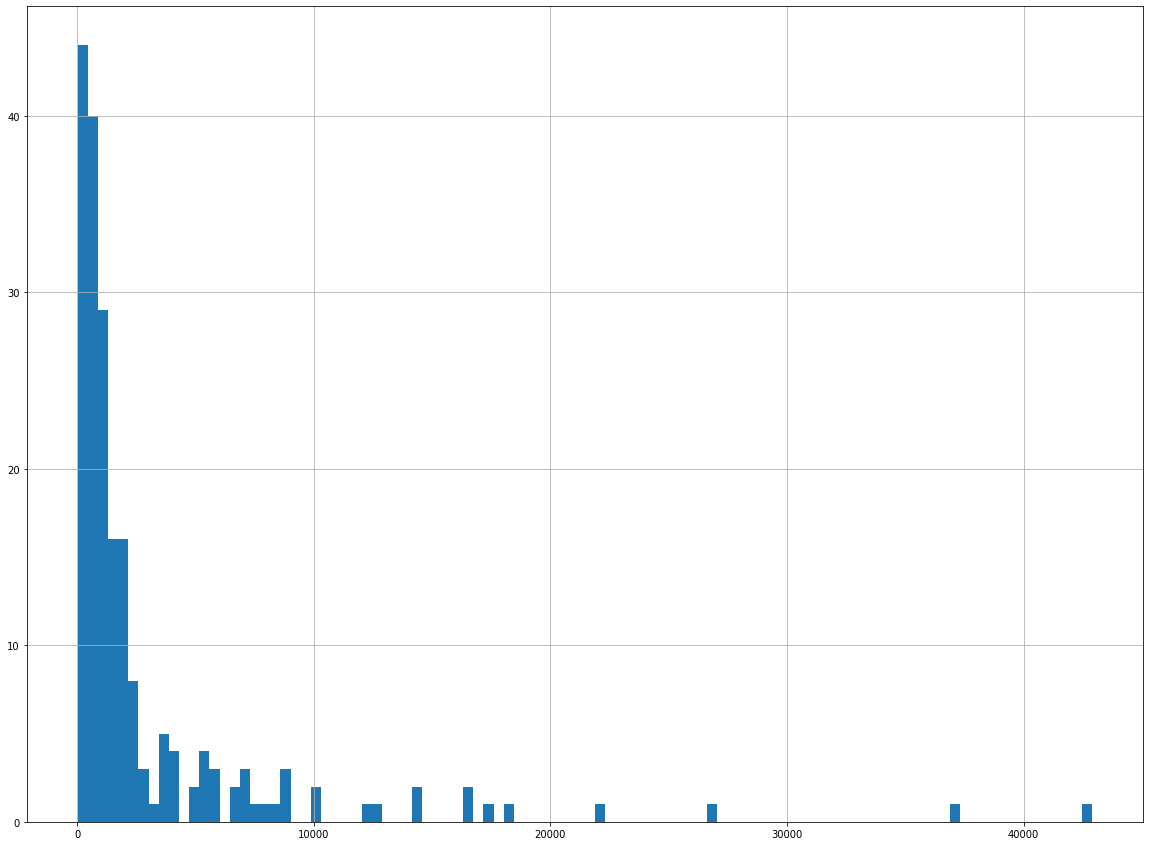

In [10]:
ax = plt.figure(figsize=(20,15)).gca()
videos["video_length"].hist(ax=ax, bins=100)
plt.show()

In [11]:
# Разделим все видео на 10 групп относительно длины по квантилям
videos["video_length_groups"] = pd.qcut(videos["video_length"], 10, labels=list(range(10)))

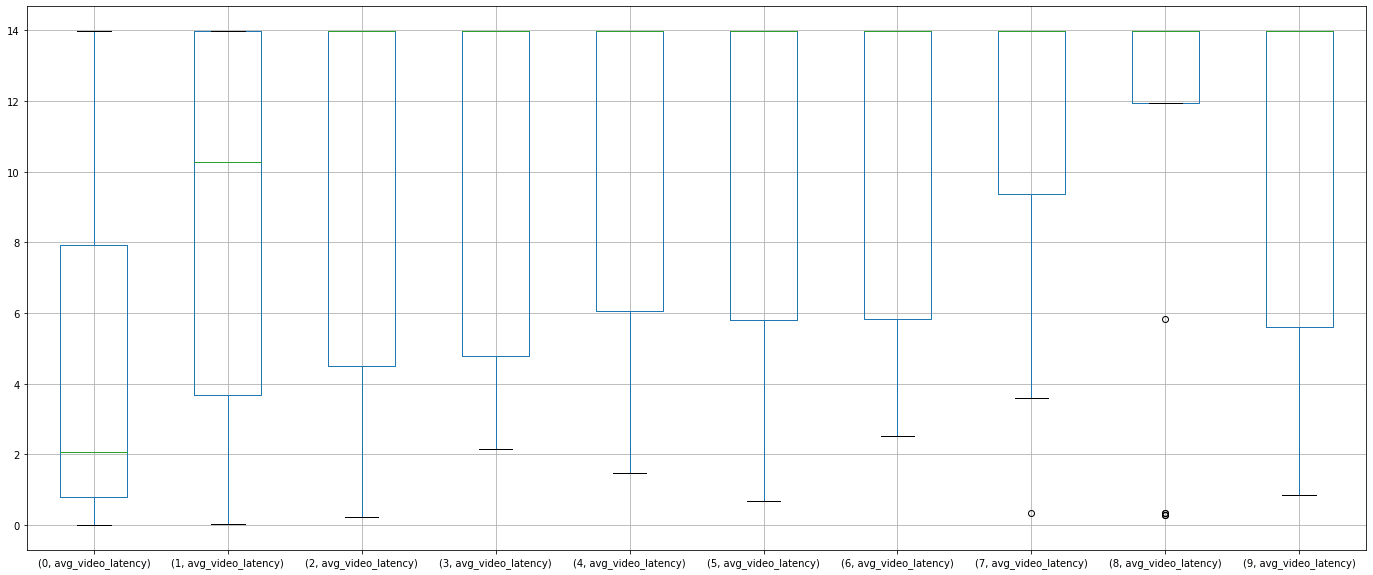

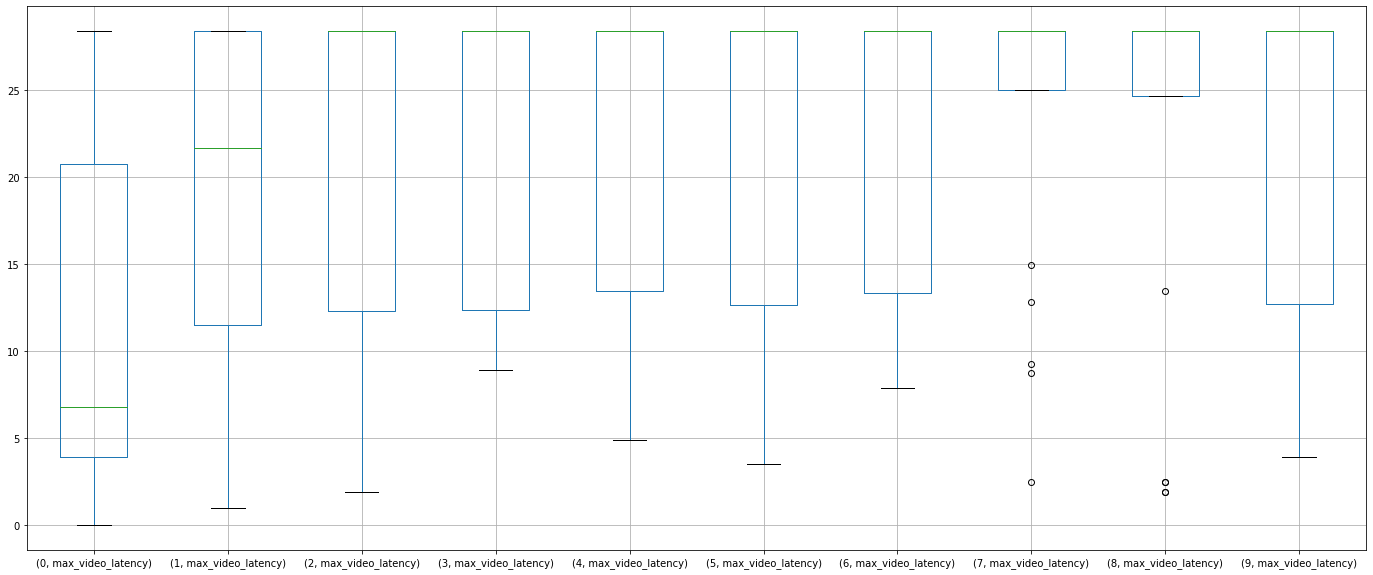

In [12]:
def plot_length_graphs():
    # Подсчитаем максимальные и средние задержки для каждого видео
    max_video_latencies = []
    avg_video_latencies = []
    for video in videos.iloc:
        max_video_latency = 0
        avg_video_latency = 0
        for node in nodes:
            cur_video_node = node_video_closest_server[node][video["video_id"]]
            cur_latency = fast_path_length[node][cur_video_node]
            if max_video_latency < cur_latency:
                max_video_latency = cur_latency
            avg_video_latency += cur_latency
        avg_video_latency /= len(nodes)

        max_video_latencies.append(max_video_latency)
        avg_video_latencies.append(avg_video_latency)

    videos["max_video_latency"] = max_video_latencies
    videos["avg_video_latency"] = avg_video_latencies

    # По новым колонкам оценим какова задержка для видео разной длины
    videos.groupby("video_length_groups").boxplot(column="avg_video_latency", subplots=False, figsize=(24,10))
    plt.show()
    videos.groupby("video_length_groups").boxplot(column="max_video_latency", subplots=False, figsize=(24,10))
    plt.show()


plot_length_graphs()

In [13]:
videos["popularity_length"] =  1 / videos["video_length"]
videos["popularity_length"] = videos["popularity_length"] / videos["popularity_length"].sum()
videos["popularity_length"] = videos["popularity_length"] * LENGTH_POPULARITY_COEF + videos["popularity"] * (1 - LENGTH_POPULARITY_COEF)

In [14]:
IMPORTANCE = "popularity_length"
reset_placement(IMPORTANCE)
place_videos(IMPORTANCE)
second_res = node_latency.copy()

4800/4800

In [15]:
second_res

{'NY54': 3.8514723895252807,
 'CMBR': 4.10163508237611,
 'CHCG': 4.424676170118435,
 'CLEV': 4.545678897386399,
 'RLGH': 4.178434830231573,
 'ATLN': 3.579803980219866,
 'PHLA': 3.665931746606876,
 'WASH': 3.7696585667437277,
 'NSVL': 3.6693127042135707,
 'STLS': 3.4011340843508493,
 'NWOR': 3.2579793608037555,
 'HSTN': 2.8789884248568276,
 'SNAN': 2.81901983865016,
 'ORLD': 5.855532937876911,
 'DNVR': 4.34484539532261,
 'KSCY': 4.281348978194313,
 'SNFN': 7.599683467221366,
 'SCRM': 4.720960212382464,
 'PTLD': 6.01050824486598,
 'STTL': 6.8281467376287,
 'SLKC': 4.62640081725592,
 'LA03': 3.933523394724973,
 'SNDG': 4.206366058899996,
 'PHNX': 4.608756164815596}

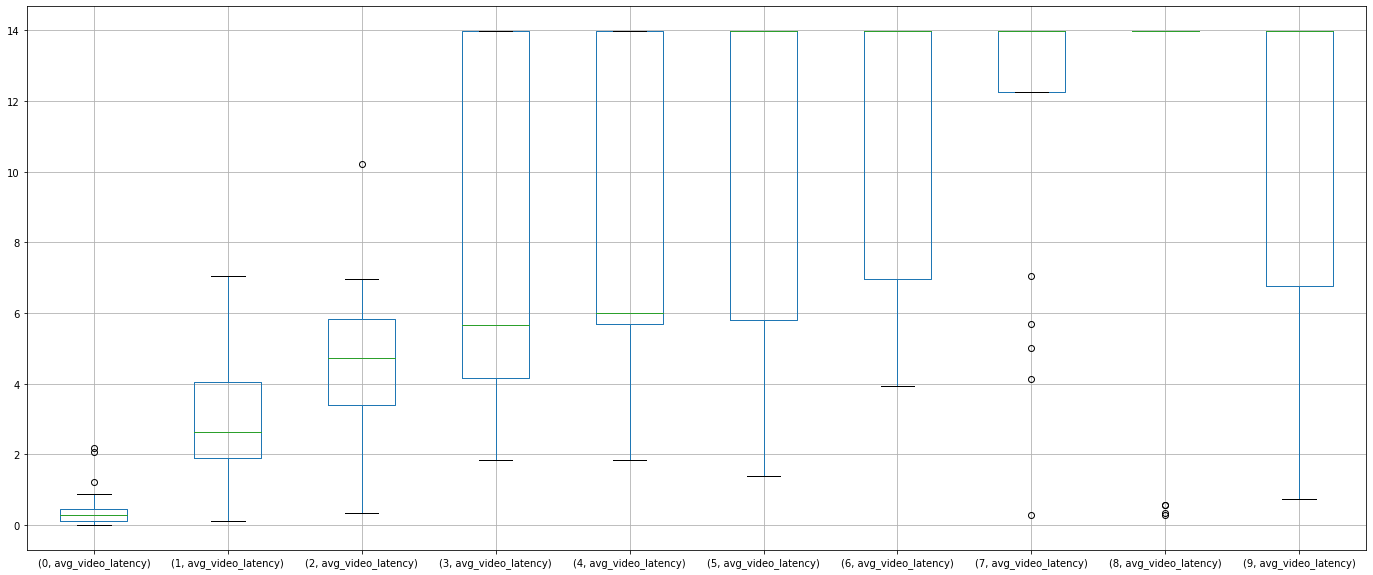

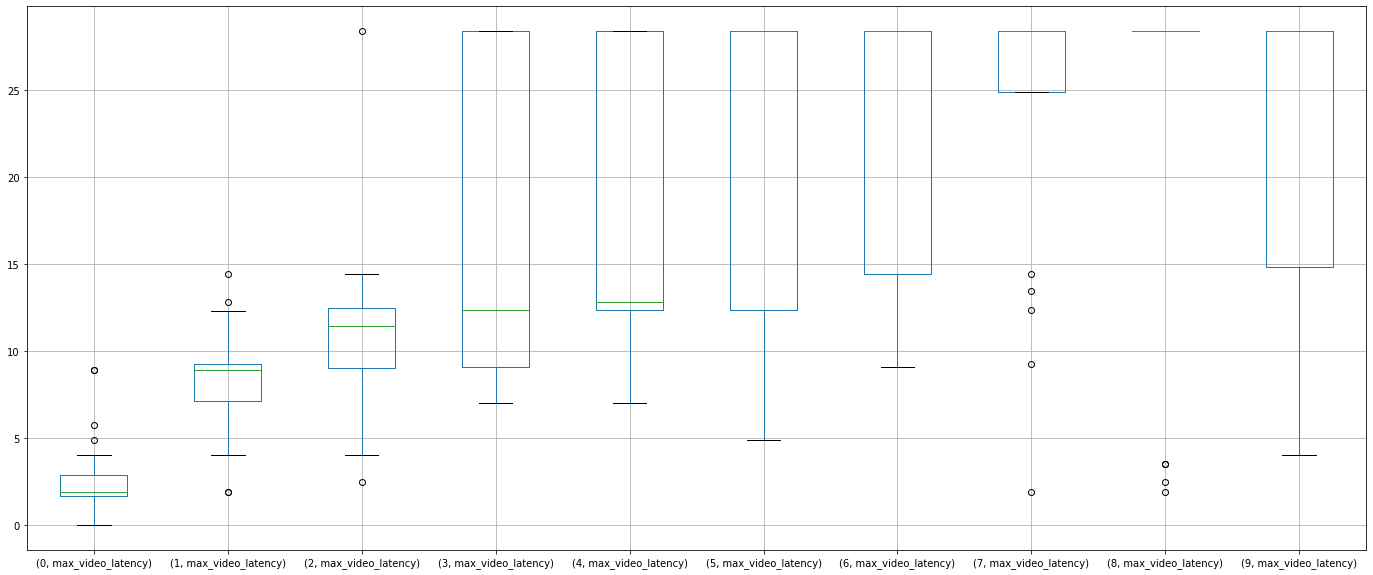

In [16]:
plot_length_graphs()

Теперь более короткие видео можно получить с меньшей задержкой

In [17]:
print(f"Видео, которые присутствуют только на оригинальном сервере: {count_videos_without_replicas()}/{videos.shape[0]}")

Видео, которые присутствуют только на оригинальном сервере: 116/200


In [18]:
def place_videos_v2(importance):
    global node_capacity, node_latency, node_with_space_latency, node_video_closest_server, node_videos
    while node_with_space_latency:
        # Выбираем узел с наибольшей задержкой
        target_node = max(node_with_space_latency, key=node_with_space_latency.get)

        # Убираем из поиска все видео размер которых превышает текущее свободное место на узле и которые уже есть на сервере
        target_videos = videos[(videos["video_size"] <= node_capacity[target_node]) & (~videos["video_id"].isin(node_videos[target_node]))]
        # Если нет видео которые можно разместить тогда убираем из рассмотрения данный узел
        if target_videos.shape[0] == 0:
            node_with_space_latency.pop(target_node)
            continue

        # Ищем видео, добавление которого на узел наилучшим образом улучшит задержку
        max_profit = 0
        target_video = None
        for video in target_videos.iloc:
            # Считаем выгоду учитывая все узлы, а не только выбранный
            sum_profit = 0
            for node in nodes:
                video_node = node_video_closest_server[node][video["video_id"]]
                profit = (fast_path_length[node][video_node] - fast_path_length[node][target_node]) * video[importance]
                if profit > 0:
                    sum_profit += profit
            if sum_profit > max_profit:
                max_profit = sum_profit
                target_video = video

        for node in nodes:
            # Определяем будет ли улучшение для узла от размещения видео на выбранном узле
            cur_video_node = node_video_closest_server[node][target_video["video_id"]]
            cur_latency = fast_path_length[node][cur_video_node]
            new_latency = fast_path_length[node][target_node]
            if cur_latency < new_latency:
                continue

            # Обновляем задержку и меняем узел, с которого данное видео будет запрашиваться
            node_latency[node] -= cur_latency * target_video["popularity"]
            node_latency[node] += new_latency * target_video["popularity"]
            node_video_closest_server[node][target_video["video_id"]] = target_node
            if node in node_with_space_latency:
                node_with_space_latency[node] -= cur_latency * target_video[importance]
                node_with_space_latency[node] += new_latency * target_video[importance]
        # Добавляем видео на узел и уменьшаем свободное место
        node_videos[target_node].append(target_video["video_id"])
        node_capacity[target_node] -= target_video["video_size"]

In [21]:
reset_placement(IMPORTANCE)
place_videos_v2(IMPORTANCE)
third_res = node_latency.copy()

4800/4800

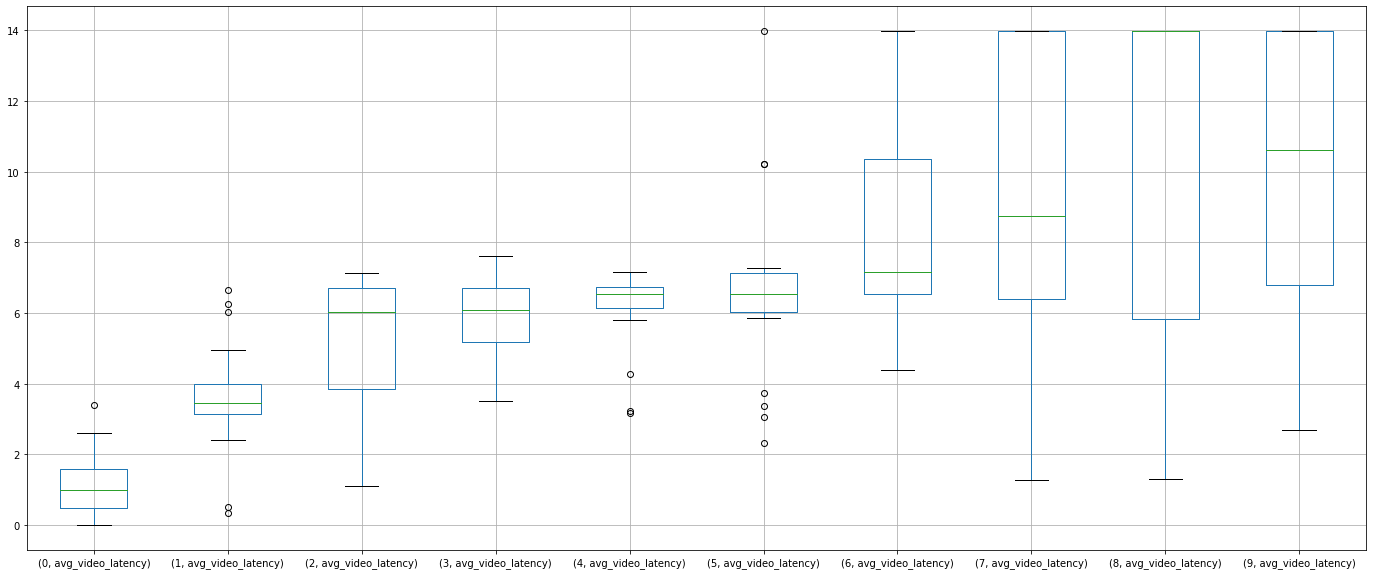

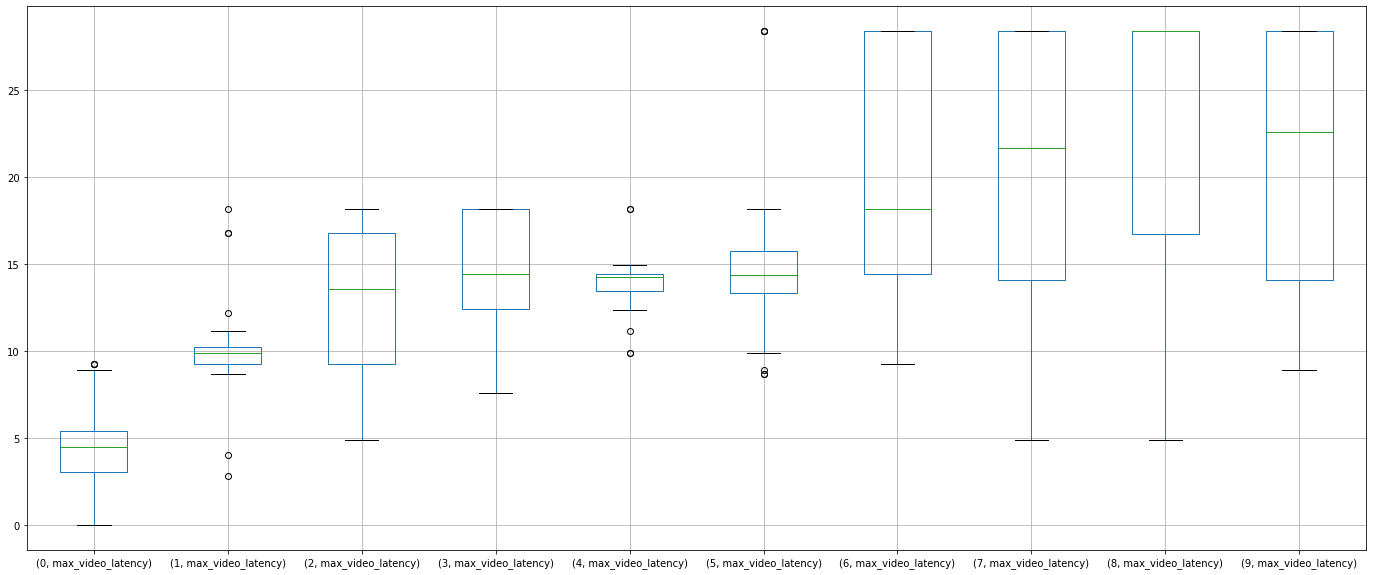

In [26]:
plot_length_graphs()

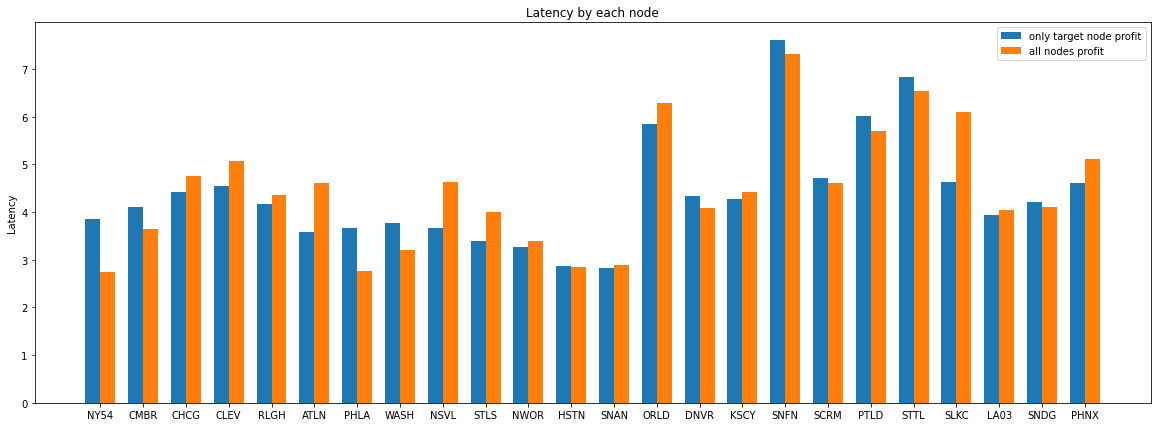

In [32]:
arr1 = []
arr2 = []
for node in nodes:
    arr1.append(second_res[node])
    arr2.append(third_res[node])

x = np.arange(len(nodes))
width = 0.35

fig, ax = plt.subplots(figsize=(20, 7))
rects1 = ax.bar(x - width/2, arr1, width, label='only target node profit')
rects2 = ax.bar(x + width/2, arr2, width, label='all nodes profit')

ax.set_ylabel('Latency')
ax.set_title('Latency by each node')
ax.set_xticks(x)
ax.set_xticklabels(nodes)
ax.legend()
plt.show()